In [263]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def plot_grayscale(image, title=None, cmap="gray"):
    if title:
        plt.title(title)
        
    plt.axis("off")
    plt.imshow(image, cmap=cmap)

def plot_freq(image, title=None, cmap="gray"):
    if title:
        plt.title(title)
        
    magnitudes = np.log1p(np.abs(image))
    plt.axis("off")
    plt.imshow(magnitudes, cmap=cmap)

<Figure size 640x480 with 0 Axes>

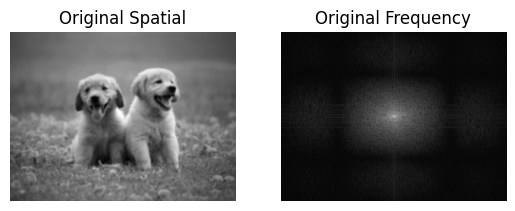

In [264]:
image_bgr = cv2.imread("../assets/dogs.jpg")

# resize and keep ar so operations will be faster
image_bgr = cv2.resize(image_bgr, (512, int(512 * image_bgr.shape[0] / image_bgr.shape[1])))

image_bgr = cv2.blur(image_bgr, (4, 4))

# convert to grayscale
image_spatial = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

# normalize the image to values in [0, 1]
image_spatial = image_spatial / 255

# fft transform
image_freq = np.fft.fft2(image_spatial)
image_freq = np.fft.fftshift(image_freq)

plt.figure()
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
plot_grayscale(image_spatial, title="Original Spatial")
plt.subplot(1, 2, 2)
plot_freq(image_freq, title="Original Frequency")

## Create the laplacian filter

According to formula (4-124) in page 290:

$$
   H(u, v) = -4 \pi^2 [ (u - \frac{P}{2})^2 + (v - \frac{Q}{2})^2 ]
$$

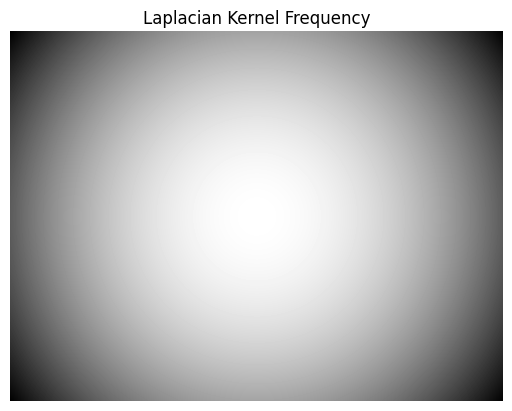

In [265]:
def create_laplacian_kernel(shape):
    P, Q = shape
    kernel = np.zeros((P, Q), dtype=np.float32)
    P_half = P / 2
    Q_half = Q / 2
    PI_square = np.pi * np.pi

    for u in range(P):
        for v in range(Q):
            d_uv = (u - P_half)**2 + (v - Q_half)**2
            kernel[u, v] = -4 * PI_square * d_uv

    return kernel

kernel_freq = create_laplacian_kernel(image_freq.shape)
plt.figure()
plot_grayscale(kernel_freq, "Laplacian Kernel Frequency")

## Calculate the Laplacian in the frequency domain

$$
\nabla^2 f(c, y) = \mathcal{F}^{-1} [ H(u, v) \cdot F(u, v) ]
$$

Where $\cdot$ is elementwise multiplication.

We will also normalize the laplacian values.

<Figure size 640x480 with 0 Axes>

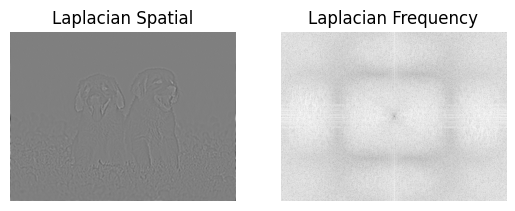

In [266]:
laplacian_freq = kernel_freq * image_freq
laplacian_spatial = np.real(np.fft.ifft2(np.fft.ifftshift(laplacian_freq)))

# normalize so the values will be in [-1, 1]
diff = laplacian_spatial.max() - laplacian_spatial.min()
minval = laplacian_spatial.min()
laplacian_spatial = ((laplacian_spatial - minval) * 2 / diff) - 1

plt.figure()
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
plot_grayscale(laplacian_spatial, title="Laplacian Spatial")
plt.subplot(1, 2, 2)
plot_freq(laplacian_freq, title="Laplacian Frequency")

### Apply final enhancement

According to (4-126) we get the final enhancement $g$ using

$$
g(x, y) = f(x, y) + c \nabla^2 f(x, y)
$$

with $c = -1$

<Figure size 640x480 with 0 Axes>

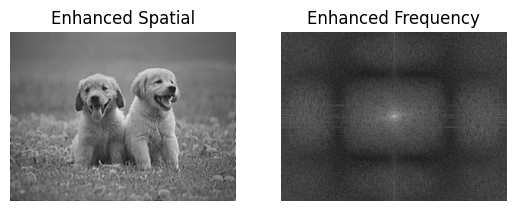

In [267]:
c = -1
enhanced_spatial = image_spatial + c * laplacian_spatial
enhanced_spatial = np.clip(enhanced_spatial, 0, 1)

enhanced_freq = np.fft.fft2(enhanced_spatial)
enhanced_freq = np.fft.fftshift(enhanced_freq)

plt.figure()
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
plot_grayscale(enhanced_spatial, title="Enhanced Spatial")
plt.subplot(1, 2, 2)
plot_freq(enhanced_freq, title="Enhanced Frequency")


### Comparison

<Figure size 640x480 with 0 Axes>

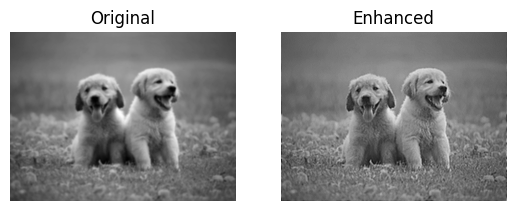

In [268]:
plt.figure()
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
plot_grayscale(image_spatial, title="Original")
plt.subplot(1, 2, 2)
plot_grayscale(enhanced_spatial, title="Enhanced")